![logo](https://climate.copernicus.eu/sites/default/files/custom-uploads/branding/LogoLine_horizon_C3S.png)

# Visualising a full climate data record of multi-sensor aerosol data

**This notebook can be run on free online platforms, such as Binder, Kaggle and Colab, or they can be accessed from GitHub. The links to run this notebook in these environments are provided here, but please note they are not supported by ECMWF.** 

[![binder](https://mybinder.org/badge.svg)](https://mybinder.org/v2/gh/ecmwf-training/c3s-training-submodule-sat-obs-atmos-comp/main?labpath=aerosol-multi-sensor-record.ipynb)
[![kaggle](https://kaggle.com/static/images/open-in-kaggle.svg)](https://kaggle.com/kernels/welcome?src=https://github.com/ecmwf-training/c3s-training-submodule-sat-obs-atmos-comp/blob/main/aerosol-multi-sensor-record.ipynb)
[![colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/ecmwf-training/c3s-training-submodule-sat-obs-atmos-comp/blob/main/aerosol-multi-sensor-record.ipynb)
[![github](https://img.shields.io/badge/Open%20in-GitHub-black?logo=github)](https://github.com/ecmwf-training/c3s-training-submodule-sat-obs-atmos-comp/blob/main/aerosol-multi-sensor-record.ipynb)

## Learning objectives 🎯

This notebook extends the practical introduction to the 
[C3S Aerosol properties gridded data from 1995 to present derived from satellite observations](https://cds.climate.copernicus.eu/cdsapp#!/dataset/satellite-aerosol-properties?tab=overview)
dataset. If you have not already done so, we encourage you to work through the [Exploring gridded data on Aerosol properties available on C3S](./aerosol-single-sensor-demonstrator.ipynb) tutorial.

Here, we will create a full Climate Data Record from 1995 to 2023. This can only be achieved by combining subsequent parts of a long term record from a sequence of similar sensors. We start by downloading the data from the Climate Data Store (CDS) and then demonstrate three use cases for monthly mean multi-sensor data records: calculate and plot a regional data record, calculate and plot a regional multi-annual mean ("climatology") and plot a regional anomaly time series.

We combine three AOD data records from three similar dual-view radiometers ATSR-2 (Along Track Scanning Radiometer no. 2), AATSR (Advanced ATSR) and SLSTR (Sea and Land Surface Temperature Radiometer). This can be done since all three instruments use the same measurement principle (conical scan which enables observing the Earth surface with two viewing directions: nadir and oblique) and have the same  set of seven visual and infrared channels. However, there are remaining differences between the instruments in data rates / sampling and most importantly, the pointing direction of the oblique view (forward for ATSR-2 and AATSR, rearward for SLSTR).

A user should be aware that slower long-term changes of atmospheric aerosols can only be seen in records of several decades while exceptionally large episodic extreme events may be visible in short records of a few years only.

## Prepare your environment

### Set up CDSAPI and your credentials

The code below will ensure that the `cdsapi` package is installed. If you have not setup your `~/.cdsapirc` file with your credenials, you can replace `None` with your credentials that can be found on the [how to api](https://cds.climate.copernicus.eu/how-to-api) page (you will need to log in to see your credentials).

In [1]:
!pip install -q cdsapi
# If you have already setup your .cdsapirc file you can leave this as None
cdsapi_key = None
cdsapi_url = None

### (Install and) Import libraries

The following code block will import the python modules required for this notebook. We will be using cdsapi for downloading the data and xarray for handling the data, and matplotlib and cartopy for plotting.

In [2]:
# Import libraries needed for the Jupyter notebook
# CDS API library
import cdsapi

# Libraries for working with multidimensional arrays
import pandas as pd
import xarray as xr

# Import earthkit aggregate for simplified computations (and ensure that it is installed)
!pip install -q earthkit-transforms
from earthkit.transforms import aggregate as ek_aggregate

# Library to work with zip-archives, OS-functions and pattern expansion
import zipfile
import os

# Libraries for plotting and visualising data
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
# We will use the PlateCarree projection for our maps
projection=ccrs.PlateCarree()

### Specify data directory

In [ ]:
# Directory to store data
# Please ensure that data_dir is a location where you have write permissions
DATADIR = './data_dir/'
# Create this directory if it doesn't exist
os.makedirs(DATADIR, exist_ok=True)

## Explore data

The variable analysed by this dataset is meant to cover the global atmospheric aerosol distribution: aerosol optical depth (total abundance). AOD is here derived from observations from several dual view radiometers using different algorithms with specific strengths and weaknesses. The datasets originate from the same sensors but are processed by different algorithms to provide a way to evaluate uncertainties (e.g. areas of good or bad agreement between them). The notebook can also be applied to Fine-Mode AOD (particles with diameter smaller than 1 micron).

The data are provided in netCDF format.

Please find further information about the dataset as well as the data in the Climate Data Store catalogue entry Aerosol properties, sections "Overview", "Download data" and "Documentation": 
- [C3S Aerosol properties gridded data from 1995 to present derived from satellite observations](https://cds.climate.copernicus.eu/datasets/satellite-aerosol-properties)

There in the "Documentation" part, one can find the Product User Guide and Specifications (PUGS) and the Algorithm Theoretical Baseline (ATBD) for further information on the different algorithms.

### Search for the data

Having selected the correct dataset, we now need to specify what product type, variables, temporal and geographic coverage we are interested in. These parameters can all be selected in the "Download data" tab. In this tab a form appears in which we can select the parameters to download.

This notebook requires a lot of data from different sensors to construct the long time-series required. The following code cells will set up some variables and options required to make the download steps in sub-sequent cells easier to modify for different selections.

To start, we need to define the varname, algorithm and region for our analysis. Furthermore, latest dataset versions for each Dual view algorithm are specified.

:::{warning}

Please remember to accept the terms and conditions of the dataset, at the bottom of the CDS download form!

:::

In [4]:
# Define the data record which shall be downloaded and visualized: varname, algorithm, region, years
variable = 'aerosol_optical_depth'
algorithm = 'SWANSEA'
region = 'Europe'
years = ['%04d'%(yea) for yea in range(1995, 2024)]


In [5]:
# Define versions of the 4 available algorithms per sensor

version_ATSR2 = {'ORAC': 'v4_02',
                'ADV': 'v4_1',
                'SWANSEA': 'v4_33',
                'ENS': 'v3_1',}
version_AATSR = {'ORAC': 'v4_02',
                'ADV': 'v4_1',
                'SWANSEA': 'v4_33',
                'ENS': 'v3_1',}
version_SLSTR = {'ORAC': 'v1_00',
                'SDV': 'v2_30',
                'SWANSEA': 'v1_12',
                'ENS': 'v2_3',}

Next, we implement definitions of some relevant regions, define the temporal coverage for each instrument in the sensor series and extract cell indices for the selected region.

In [6]:
# Definition of different regions to choose from

extent = {
    # 'Region' : [lon_min, lon_max, lat_min, lat_max],
    'Europe': [-15, 50, 36, 60],
    'Boreal': [-180, 180, 60, 85],
    'Asia_North': [50, 165, 40, 60],
    'Asia_East': [100, 130, 5, 41],
    'Asia_West': [50, 100, 5, 41],
    'China_South-East': [103, 135, 20, 41],
    'Australia': [100, 155, -45, -10],
    'Africa_North': [-17, 50, 12, 36], 
    'Africa_South': [-17, 50, -35, -12],
    'South_America': [-82, -35, -55, 5],
    'North_America_West': [-135, -100, 13, 60],
    'North_America_East': [-100, -55, 13, 60],
    'Indonesia': [90, 165, -10, 5],
    'Atlanti_Ocean_dust': [-47, -17, 5, 30],
    'Atlantic_Ocean_biomass_burnig': [-17, 9, -30, 5],
    'World': [-180, 180, -90, 90],
    'Asia': [50, 165, 5, 60],
    'North_America': [-135, -55, 13, 60], 
    'dust_belt': [-80, 120, 0, 40], 
    'India': [70, 90, 8, 32], 
    'Northern_Hemisphere': [-180, 180, 0, 90], 
    'Southern_Hemisphere': [-180, 180, -90, 0],
}

In [7]:
# Definition of available years per sensor and the combined data record
years_ATSR2 = ['1995', '1996', '1997', '1998', '1999', '2000', '2001', '2002']
years_AATSR = ['2003', '2004', '2005', '2006', '2007', '2008', '2009', '2010', '2011']
years_SLSTR = ['2017', '2018', '2019', '2020', '2021', '2022','2023']  
years_dual = years_ATSR2 + years_AATSR + years_SLSTR
months = ['%02d'%(mnth) for mnth in range(1,13)]

The following code cell deduces the variable name inside the netCDF files based on the human readable variable name used by the CDS and the selected algorithm.

In [8]:
# Run the following code lines to automatically replace all variable names which are inconsistent, so that you need not care any further

if variable == 'aerosol_optical_depth':
    if algorithm == 'ens':
        varname = 'AOD550'
    else:
        varname = 'AOD550_mean'
elif variable == 'fine_mode_aerosol_optical_depth':
    if algorithm == 'ens':
        varname = 'FM_AOD550'
    else:
        varname = 'FM_AOD550_mean'
elif variable == 'dust_aerosol_optical_depth':
    if algorithm == 'ens':
        varname = 'DAOD550'
    elif algorithm == 'lmd':
        varname = 'Daod550'
    elif algorithm == 'imars':
        varname = 'D_AOD550'
    else:
        varname = 'D_AOD550_mean'

### Download the data

We now download the full time record of one dual view algorithm 1995 - 2022:
The following download may take ~ 15 min (exact time needed depends on your network and hardware).
Do not worry, as there may be many error messages for missing months in gaps.

In [ ]:
# Define the API for the CDS access
c = cdsapi.Client()

# Run the following code lines to automatically replace algorithm names specifically per sensor (ADV / SDV only)

dataset = 'satellite-aerosol-properties'

ATSR2_algorithm = 'ADV' if algorithm == 'ADV/SDV' else algorithm
request_ATSR2 = {
    'time_aggregation': 'monthly_average',
    'variable': variable,
    'sensor_on_satellite': 'atsr2_on_ers2',
    'algorithm': ATSR2_algorithm.lower(),
    'year': years_ATSR2, 
    'month': months,
    'version': version_ATSR2[ATSR2_algorithm]
}

AATSR_algorithm = 'ADV' if algorithm == 'ADV/SDV' else algorithm
request_AATSR = {
    'time_aggregation': 'monthly_average',
    'variable': variable,
    'sensor_on_satellite': 'aatsr_on_envisat',
    'algorithm': AATSR_algorithm.lower(),
    'year': years_AATSR, 
    'month': months,
    'version': version_AATSR[AATSR_algorithm]
}

SLSTR_algorithm = 'SDV' if algorithm == 'ADV/SDV' else algorithm
request_SLSTR = {
    'time_aggregation': 'monthly_average',
    'variable': variable,
    'sensor_on_satellite': 'slstr_on_sentinel_3a',
    'algorithm': SLSTR_algorithm.lower(),
    'year': years_SLSTR, 
    'month': months,
    'version': version_SLSTR[SLSTR_algorithm]
}

ATSR2_file_name = os.path.join(DATADIR, f"ATSR2_{ATSR2_algorithm}.zip")
if not os.path.exists(ATSR2_file_name):
    print("Downloading data for ATSR2")
    c.retrieve(dataset, request_ATSR2, ATSR2_file_name)
else:
    print("Data for ATSR2 already downloaded")

AATSR_file_name = os.path.join(DATADIR, f"AATSR_{AATSR_algorithm}.zip")
if not os.path.exists(AATSR_file_name):
    print("Downloading data for AATSR")
    c.retrieve(dataset, request_AATSR, AATSR_file_name)
else:
    print("Data for AATSR already downloaded")

SLSTR_file_name = os.path.join(DATADIR, f"SLSTR_{SLSTR_algorithm}.zip")
if not os.path.exists(SLSTR_file_name):
    print("Downloading data for SLSTR")
    c.retrieve(dataset, request_SLSTR, SLSTR_file_name)
else:
    print("Data for SLSTR already downloaded")

all_files = {
    'ATSR2': ATSR2_file_name,
    'AATSR': AATSR_file_name,
    'SLSTR': SLSTR_file_name,
}

Data for ATSR2 already downloaded
Data for ATSR2 already downloaded
Data for ATSR2 already downloaded


Next, we unpack the data.

### Inspect data

In [11]:
# Unpack the downloaded data to a predefined sub directory for the selected dataset 
# (which can be used for future applications of the Jupyter notebook without repeating the download)
filelist = {}
for sensor, zip_file in all_files.items():
    with zipfile.ZipFile(zip_file, 'r') as zip_ref:
        sensor_files = [os.path.join(DATADIR, f) for f in zip_ref.namelist()]
        sensor_files.sort()
        filelist[sensor] = sensor_files
        zip_ref.extractall(DATADIR)
    print(f"Extracted {len(filelist[sensor])} files for {sensor}")

Extracted 85 files for ATSR2
Extracted 108 files for AATSR
Extracted 72 files for SLSTR


We will use `xarray.open_mfdataset` to open all the files we have downloaded. Not only is this useful for reading data from multiple files, it also uses dask to "lazily loads" the data such that we do not load too much into memory in one do. We create one dataset per sensor and add them to a dictionary for simpler reference later.

As the data files do not contain a date/time dimension, we will deduced this from the file names and add to the xarray manually.

The output of the cell below shows the `xarray.Dataset` for the AATSR component of the time-series. You can explore the data variables, coordinates and all the other metadata found in the the files.

In [12]:
ds_dict = {}

for sensor, files in filelist.items():
    date_list = [pd.to_datetime(os.path.basename(f)[:6], format='%Y%m') for f in filelist[sensor]]
    date_array = xr.DataArray(date_list, dims="time", name="time")
    date_array
    # Open all files while adding time as a coordinate
    ds = xr.open_mfdataset(
        filelist[sensor],
        concat_dim=date_array,
        combine="nested",
    )
    ds_dict[sensor] = ds

ds_dict["AATSR"]


<xarray.Dataset> Size: 1GB
Dimensions:                       (time: 108, latitude: 180, longitude: 360)
Coordinates:
  * latitude                      (latitude) float32 720B -89.5 -88.5 ... 89.5
  * longitude                     (longitude) float32 1kB -179.5 ... 179.5
  * time                          (time) datetime64[ns] 864B 2003-01-01 ... 2...
Data variables: (12/51)
    pixel_count                   (time, latitude, longitude) float64 56MB dask.array<chunksize=(1, 180, 360), meta=np.ndarray>
    AOD550_mean                   (time, latitude, longitude) float32 28MB dask.array<chunksize=(1, 180, 360), meta=np.ndarray>
    AOD550_sdev                   (time, latitude, longitude) float32 28MB dask.array<chunksize=(1, 180, 360), meta=np.ndarray>
    AOD670_mean                   (time, latitude, longitude) float32 28MB dask.array<chunksize=(1, 180, 360), meta=np.ndarray>
    AOD670_sdev                   (time, latitude, longitude) float32 28MB dask.array<chunksize=(1, 180, 360), meta=np.ndarray>
    AOD870_mean                   (time, latitude, longitude) float32 28MB dask.array<chunksize=(1, 180, 360), meta=np.ndarray>
    ...                            ...
    AOD1600_uncertainty_min       (time, latitude, longitude) float32 28MB dask.array<chunksize=(1, 180, 360), meta=np.ndarray>
    AOD1600_uncertainty_max       (time, latitude, longitude) float32 28MB dask.array<chunksize=(1, 180, 360), meta=np.ndarray>
    cloud_fraction_mean           (time, latitude, longitude) float32 28MB dask.array<chunksize=(1, 180, 360), meta=np.ndarray>
    cloud_fraction_sdev           (time, latitude, longitude) float32 28MB dask.array<chunksize=(1, 180, 360), meta=np.ndarray>
    surface_type_number_mean      (time, latitude, longitude) float32 28MB dask.array<chunksize=(1, 180, 360), meta=np.ndarray>
    surface_type_number_sdev      (time, latitude, longitude) float32 28MB dask.array<chunksize=(1, 180, 360), meta=np.ndarray>
Attributes: (12/38)
    Conventions:                CF-1.6
    tracking_id:                6cd735e3-ff56-4e1e-9961-c4311e335252
    naming_authority:           uk.ac.su.aatsraerosol
    title:                      AARDVARC CCI aerosol product level 3
    product_version:            4.33
    summary:                    This dataset contains the level-3 daily mean ...
    ...                         ...
    history:                    Level 3 product from Swansea algorithm
    keywords:                   satellite,observation,atmosphere
    keywords_vocabulary:        NASA Global Change Master Directory (GCMD) Sc...
    standard_name_vocabulary:   NetCDF Climate and Forecast (CF) Metadata Con...
    license:                    ESA CCI Data Policy: free and open access
    inputfilelist:              ['20030101-ESACCI-L3C_AEROSOL-AER_PRODUCTS-AA...

### Bias correction for SLSTR

Since the validation showed a significant bias for SLSTR algorithms with some but limited regional variations, we have to subtract it before combining the time series. Note that we use a global average bias here, while a more sophisticated correction will use regional biases. The bias correction was determined by comparison to AOD data from the global sun photometer network AERONET.

In [13]:
# Define global bias corrections for SLSTR per algorithm
SLSTR_biases = {
    'ORAC': 0.06,
    'SDV': 0.00,
    'SWANSEA': 0.045,
    'ENS': 0.03,
}

ds_dict["SLSTR"][varname] = ds_dict["SLSTR"][varname] - SLSTR_biases[SLSTR_algorithm]

## Use case 1: extract and plot long time series

In this first use case we will plot a long time-series of the data, which covers all three sensors, with a data gap between AATSR and SLSTR. 

First we select our region and concatenate the data from the different sensors into a single `xarray.DataArray`. We can then calculate the spatial mean by averaging in the `latitude` and `longitude` dimensions.

The output of the cell below shows the dataset created for our mean time series.

In [ ]:
ds_full_timeseries = xr.concat(ds_dict.values(), dim="time")
# Plot the combined data record
# Create the time-series DataArray by looping over the three sensors
region_slice = dict(
    latitude=slice(extent[region][2], extent[region][3]),
    longitude=slice(extent[region][0], extent[region][1])
)
ds_region = ds_full_timeseries.sel(**region_slice)

# Calculate the mean time series for the region
mean_time_series = ds_region[varname].mean(dim=["latitude", "longitude"])

# So that we can visualise the gaps in data, we will reindex with a complete time index
time_index = pd.date_range(
    start=f"{years[0]}-01-01", end=f"{years[-1]}-12-31", freq='MS'
)
mean_time_series = mean_time_series.reindex(time=time_index)
mean_time_series

<xarray.DataArray 'AOD550_mean' (time: 348)> Size: 1kB
dask.array<where, shape=(348,), dtype=float32, chunksize=(1,), chunktype=numpy.ndarray>
Coordinates:
  * time     (time) datetime64[ns] 3kB 1995-01-01 1995-02-01 ... 2023-12-01

Then we can plot using `matplotlib`

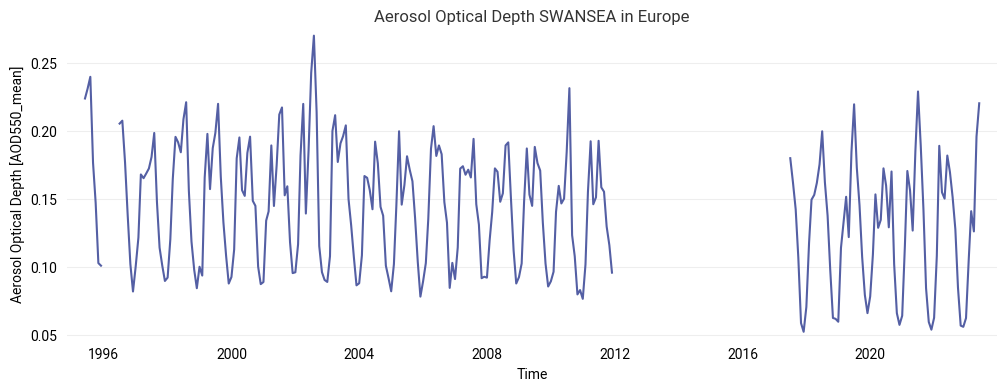

In [15]:
# A prettified name for the variable
variable_pretty = variable.title().replace("_", " ")
fig, ax = plt.subplots(figsize=(12,4))
mean_time_series.plot(ax=ax)
ax.set_title(f"{variable_pretty} {algorithm} in {region}")
ax.set_ylabel(f"{variable_pretty} [{varname}]")
ax.set_xlabel("Time")

#  To save the figure, uncomment the following line, or use the save button in the plot window
# plt.savefig(f"{DATADIR}/timeseries_{variable}_{algorithm}_{region}.png", dpi=500, bbox_inches='tight')
plt.show()

**FIGURE 1:** This time series shows the long term behaviour of aerosol properties in the selected region. Note that a global bias correction was applied for the last part (SLSTR) which may be a bit too large for this region.

## Use case 2: calculate and plot a multi-annual mean ("climatology")

We calculate a monthly "climatology" (multi-annual mean) for each sensor in the time series using `earthkit-transforms`. The multi-annual means are calculated separately per sensor, since there is no overlap between AATSR and SLSTR which would allow a relative bias correction without extrapolation. Finally, we resample the climatologies onto the original time-index of the input data for the subsequent plot, i.e. for ATSR-2 (1995-2002), AATSR (2003-2011) and SLSTR (2017-2022).

The output of the cell below shows the monthly "climatology" for the AATSR sensor, 

In [ ]:
climate_dict = {}
climate_extended_dict = {}
for sensor, ds in ds_dict.items():
    # Select the region of interest and calculate the spatial mean
    ds_region = ds.sel(**region_slice)
    ds_spatial_mean = ds_region[varname].mean(dim=["latitude", "longitude"])

    # Calculate the climatology for the spatial mean and then construct a new dataset for these variables
    ds_spatial_mean_climatology_mean = ek_aggregate.climatology.monthly_mean(ds_spatial_mean)
    ds_spatial_mean_climatology_std = ek_aggregate.climatology.monthly_std(ds_spatial_mean)

    climate_ds = xr.Dataset({
        f"{varname}_mean": ds_spatial_mean_climatology_mean.rename(f"{varname}_mean"),
        f"{varname}_std": ds_spatial_mean_climatology_std.rename(f"{varname}_std"),
    })
    climate_dict[sensor] = climate_ds

    # Resample the climatology onto the original time index for plotting
    months_array = ds_spatial_mean.time.dt.month
    climate_extended_dict[sensor] = climate_ds.sel(month=months_array).drop_vars("month")

climate_dict["AATSR"]

<xarray.Dataset> Size: 192B
Dimensions:           (month: 12)
Coordinates:
  * month             (month) int64 96B 1 2 3 4 5 6 7 8 9 10 11 12
Data variables:
    AOD550_mean_mean  (month) float32 48B dask.array<chunksize=(1,), meta=np.ndarray>
    AOD550_mean_std   (month) float32 48B dask.array<chunksize=(1,), meta=np.ndarray>

Now we plot the time series with the sensor specific climatologies. We start by merging the reindexed climatology data from the three sensors into a single `xarray.Dataset`.

In [17]:
climate_series = xr.concat(climate_extended_dict.values(), dim="time")
climate_series = climate_series.reindex(time=time_index)
climate_series


<xarray.Dataset> Size: 6kB
Dimensions:           (time: 348)
Coordinates:
  * time              (time) datetime64[ns] 3kB 1995-01-01 ... 2023-12-01
Data variables:
    AOD550_mean_mean  (time) float32 1kB dask.array<chunksize=(1,), meta=np.ndarray>
    AOD550_mean_std   (time) float32 1kB dask.array<chunksize=(1,), meta=np.ndarray>

We now plot the climatology mean +/- standard deviation, alongside the original time-series data.

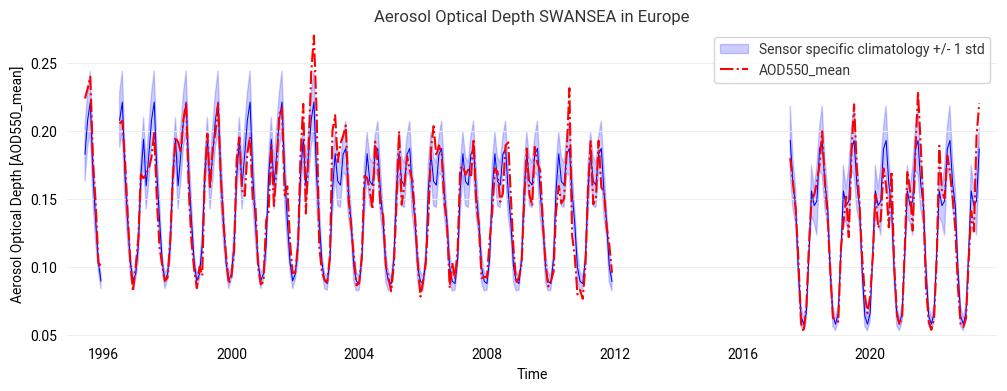

In [18]:
# Plot the time series overlayed with the annually repeated climatology

# A prettified name for the variable
variable_pretty = variable.title().replace("_", " ")
fig, ax = plt.subplots(figsize=(12,4))

# Plot the climate mean +/- 1 standard deviation using fill_between
ax.fill_between(
    x=climate_series.time,
    y1=climate_series[f"{varname}_mean"] - climate_series[f"{varname}_std"],
    y2=climate_series[f"{varname}_mean"] + climate_series[f"{varname}_std"],
    color="blue", alpha=0.2, label="Sensor specific climatology +/- 1 std"
)
# Plot the climatology and the mean time series
climate_series[f"{varname}_mean"].plot(
    ax=ax, color="blue", linewidth=0.75,
    # label="Sensor specific climatology"
)

mean_time_series.plot(ax=ax, label=varname, color="red", linestyle="-.")
ax.set_title(f"{variable_pretty} {algorithm} in {region}")
ax.set_ylabel(f"{variable_pretty} [{varname}]")
ax.set_xlabel("Time")
ax.legend()

plt.show()

**FIGURE 2:** This time series plotted over repeated annual climatologies (per sensor) already indicates any episodic events outside the long-term variabiliy. Note that a global bias correction was applied for the last part (SLSTR) which may be a bit too large for this region.

## Use case 3: calculate and plot the anomaly time series

In [ ]:
anomaly_dict = {}
for sensor, ds in ds_dict.items():
    # Select the region of interest and calculate the spatial mean
    ds_region = ds.sel(**region_slice)
    ds_spatial_mean = ds_region[varname].mean(dim=["latitude", "longitude"])

    # We now compute the anomaly, using the previously calculated climatology
    ds_spatial_mean_anomaly = ek_aggregate.climatology.anomaly(
        ds_spatial_mean, climatology=climate_dict[sensor][f"{varname}_mean"],
        frequency="month"
    )
    anomaly_dict[sensor] = ds_spatial_mean_anomaly.to_dataset()

anomaly_dict["AATSR"]

<xarray.Dataset> Size: 1kB
Dimensions:              (time: 108)
Coordinates:
  * time                 (time) datetime64[ns] 864B 2003-01-01 ... 2011-12-01
Data variables:
    AOD550_mean_anomaly  (time) float32 432B dask.array<chunksize=(1,), meta=np.ndarray>

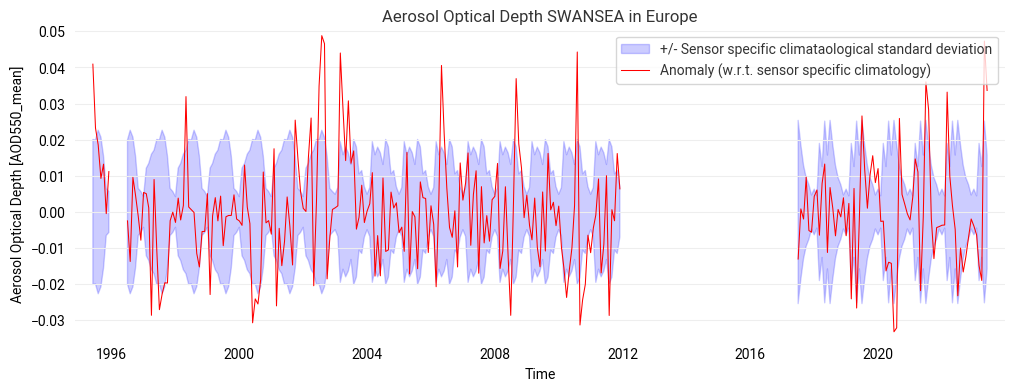

In [20]:
# concatenate the anomaly datasets
anomaly_series = xr.concat(anomaly_dict.values(), dim="time")
anomaly_series = anomaly_series.reindex(time=time_index)

# Create a figure for plotting the data
fig, ax = plt.subplots(figsize=(12,4))

# Plot the climate mean +/- 1 standard deviation using fill_between
ax.fill_between(
    x=climate_series.time,
    y1=-climate_series[f"{varname}_std"],
    y2=climate_series[f"{varname}_std"],
    color="blue", alpha=0.2,
    label="+/- Sensor specific climataological standard deviation"
)
# Plot the climatology and the mean time series
anomaly_series[f"{varname}_anomaly"].plot(
    ax=ax, color="red", linewidth=0.75,
    label="Anomaly (w.r.t. sensor specific climatology)"
)
ax.set_title(f"{variable_pretty} {algorithm} in {region}")
ax.set_ylabel(f"{variable_pretty} [{varname}]")
ax.set_xlabel("Time")
ax.legend()

#  To save the figure, uncomment the following line, or use the save button in the plot window
# plt.savefig(f"{DATADIR}/anomaly_{variable}_{algorithm}_{region}.png", dpi=500, bbox_inches='tight')

plt.show()

**FIGURE 3:** This anomaly record shows more clearly those episodic extreme events as outliers outside the shaded long-term variability and possibly also any trend of the data record in this region (e.g. decreases in Europe or the U.S., increases in India or on Sout-Eact China increases before ~2008 and decreases since ~2012).

## Get more information about aerosol properties and the Climate Data Store

- [C3S Aerosol properties gridded data from 1995 to present derived from satellite observations](https://cds.climate.copernicus.eu/datasets/satellite-aerosol-properties)
- [About the Climate Data Store](https://cds.climate.copernicus.eu/)
- [About the Toolbox documentation](https://cds.climate.copernicus.eu/toolbox/doc/index.html)

## References

[Product User Guide for CDS Aerosol Properties](http://wdc.dlr.de/C3S_312b_Lot2/Documentation/AER/C3S2_312a_Lot2_PUGS_AER_latest.pdf)

[Thomas Popp, Gerrit de Leeuw, Christine Bingen, Christoph Brühl, Virginie Capelle, Alain Chedin, 
Lieven Clarisse, Oleg Dubovik, Roy Grainger, Jan Griesfeller, Andreas Heckel, Stefan Kinne, Lars Klüser, 
Miriam Kosmale, Pekka Kolmonen, Luca Lelli, Pavel Litvinov, Linlu Mei, Peter North, Simon Pinnock, 
Adam Povey, Charles Robert, Michael Schulz, Larisa Sogacheva, Kerstin Stebel, Deborah Stein Zweers, 
Gareth Thomas, Lieuwe Gijsbert Tilstra, Sophie Vandenbussche, Pepijn Veefkind, Marco Vountas and 
Yong Xue, Development, Production and Evaluation of Aerosol Climate Data Records from European 
Satellite Observations (Aerosol_cci), Remote Sensing, 8, 421; doi:10.3390/rs8050421, 2016](https://www.mdpi.com/2072-4292/8/5/421)
